# Notes on Computing the Rollout Acquisition Function
## Considerations
- Using expected improvement as a control variate doesn't behave as anticipated. You can inspect the difference between acquisitions evaluated with or without this control variate by setting the named argument in, simulate_trajectory, variance_reduction to false or true, i.e.: `simulate_trajectory(..., variance_reduction=true)`. The logic for implementing the EI control variate is located at `src/rollout.jl`.

In [13]:
using Distributions
using LinearAlgebra
using Plots

All the necessary imports for our computations of interest

In [14]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

generate_initial_guesses (generic function with 1 method)

## Basic Setup

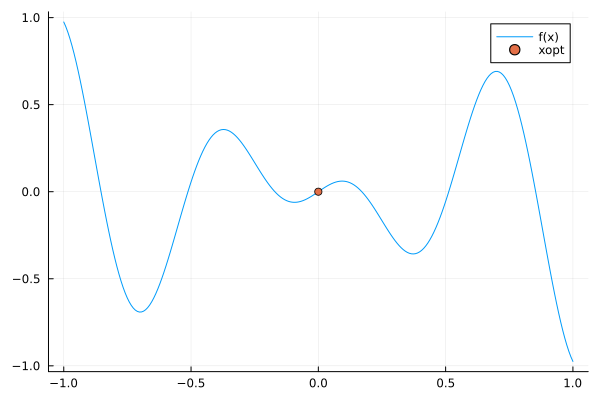

In [15]:
# Visualize 1D test function
testfn = TestLinearCosine1D(1., 9.2)
tplot(testfn)

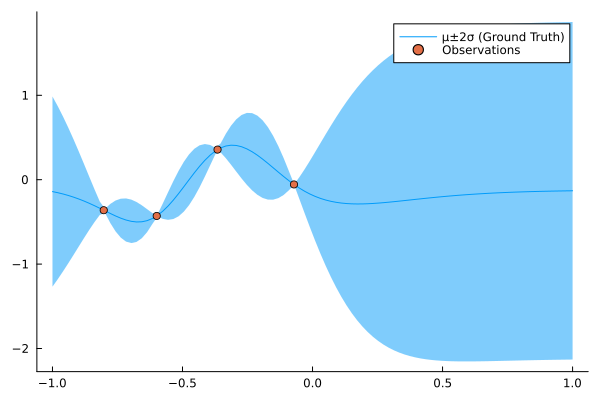

In [34]:
MC_SAMPLES = 1000
NUMBER_OF_STARTS = 8
HORIZON = 1
USE_LDS = true
INITIAL_SAMPLES = 4

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)

lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence and standard pseudo-random sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)

# Initialize shared memory for solving base policy in parallel. These values
# are passed to the simulate_trajectory function. We solve the inner policy
# with `NUMBER_OF_STARTS` random starts.
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
yinit = testfn.f.(eachcol(Xinit))

# Fit surrogate with hyperparameters learned via MLE
sur = optimize_hypers_optim(
    fit_surrogate(ψ, Xinit, yinit; σn2=σn2),
    kernel_matern52
)
plot1D(sur, xmin=first(lbs), xmax=first(ubs))

## Dense Evaluation of Rollout Acquisition Function

In [ ]:
GET_DISTRIBUTION = true
domain = first(lbs):.01:first(ubs)
# Simulate trajectory returns the acqusition, gradient of acquisition and their standard errors
trajectory_payloads = zeros(length(domain), 4)
distributions = []


for (i, x0) in enumerate(domain)
    print("|")
    tp.x0[:] = [x0]

    outcome = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
        candidate_locations=candidate_locations, candidate_values=candidate_values,
        get_distribution=GET_DISTRIBUTION
    )
    trajectory_payloads[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]

    if GET_DISTRIBUTION
        push!(distributions, outcome[end])
    end
end

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Visualize the acquisition

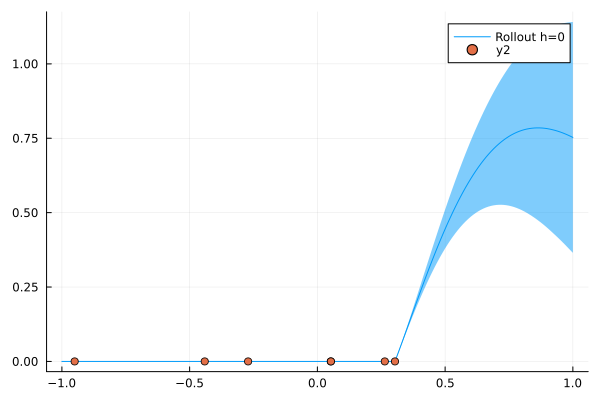

In [21]:
plot(
    domain,
    trajectory_payloads[:, 1],
    ribbons=trajectory_payloads[:, 3],
    label="Rollout h=$HORIZON"
)
scatter!(sur.X', zeros(length(sur.X')))

Investigate the distribution associated with some arbitrary point

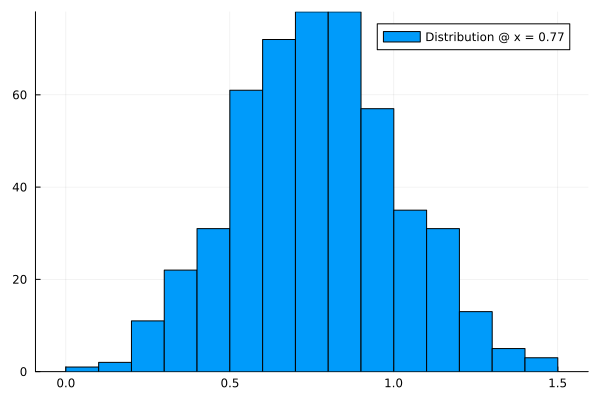

In [32]:
index = rand(1:length(distributions))
histogram(distributions[index], label="Distribution @ x = $(domain[index])")